# Distance Metrics for Customer Segementation Lab

## Business Scenario:
You've recently joined a retail analytics company as a junior data scientist. Your first project involves helping a national clothing retailer better understand their customer base to improve their marketing campaigns.

The marketing team has collected data about their customers' purchasing behaviors and demographics, but they're struggling to effectively segment customers for targeted promotions. They believe that "similar" customers should receive similar promotions, but they need your help to define and measure this similarity in a meaningful way.

Your task is to implement different distance metrics to compare customers and identify which customers are most similar to each other based on their shopping behaviors and demographics. This will allow the marketing team to create more personalized and effective promotions.

The process you'll follow consists of these key steps:

- Define what "similarity" means in the context of retail customers
- Preprocess and normalize the customer data
- Implement various distance metrics to compare customers
- Analyze how different metrics affect customer similarity
- Create a simple recommendation system based on customer similarity

## Part 1: Load and Explore the Customer Data
The dataset contains information about retail customers, including:

- Annual income
- Age
- Years as customer
- Monthly spending on different product categories (clothing, accessories, footwear)

In [1]:
# CodeGrade step0
# Run this cell without changes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity

# Load the customer data
customers_df = pd.read_csv('retail_customers.csv')

In [2]:
# Run this cell without changes
# Display the first few rows and basic information
print(customers_df.head())
print(customers_df.info())
print(customers_df.describe())

   customer_id gender  age  income  years_customer  clothing_spend  \
0            1      F   34   58000             5.2             150   
1            2      M   42   72000             8.7              95   
2            3      F   28   45000             2.1             210   
3            4      M   55   95000            12.5             180   
4            5      F   39   68000             6.8             250   

   accessories_spend  footwear_spend preferred_channel     region  
0                 45              80            online  northeast  
1                 25             120             store    midwest  
2                 85             105            online       west  
3                115             135             store  southeast  
4                 95              90            online    midwest  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------        

There are non numerical features that need to be correctly handled before you can consider calculating distance metrics. Identify which two columns contain binary data (as a list of column names - strings) and also identify which column contains truly categorical data. Use additional cells if needed but ensure your answer is assigned below.

In [6]:
# CodeGrade step1
# List of column names

print(customers_df['gender'].unique())
print(customers_df['preferred_channel'].unique())
binary_cols = ['gender', 'preferred_channel']

# Single column name as string
print(customers_df['region'].unique())
cat_col = 'region'

['F' 'M']
['online' 'store']
['northeast' 'midwest' 'west' 'southeast']


## Part 2: Preprocess the Customer Data
Before calculating distances, you need to prepare the data:
- Select relevant features for comparison (all)
- Normalize the numerical features to ensure fair comparison
- Handle categorical variables appropriately


In [12]:
# CodeGrade step2
# Select numerical features for distance calculation
numerical_features = ['age', 'income', 'years_customer', 'clothing_spend',
                     'accessories_spend', 'footwear_spend']
feature_matrix = customers_df[numerical_features].values

# Select categorical features to encode before distance calculation
binary_cols.append(cat_col)
categorical_features = binary_cols

# Normalize numerical features
scaler = MinMaxScaler()
normalized_numerical = scaler.fit_transform(feature_matrix)

# Handle binary and categorical features with one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical = encoder.fit_transform(customers_df[categorical_features])

# Combine numerical and categorical features
normalized_features = np.hstack((normalized_numerical, encoded_categorical))

# Create a list of feature names for the encoded data
encoded_feature_names = list(encoder.get_feature_names_out())
features = numerical_features + encoded_feature_names

# Create new dataframe with normalized and encoded data - should have 11 columns in total
features_df = pd.DataFrame(normalized_features, columns=features)
features_df.head()

,age,income,years_customer,clothing_spend,accessories_spend,footwear_spend,gender_M,preferred_channel_store,region_northeast,region_southeast,...,region_west,region_northeast,region_southeast,region_west,region_northeast,region_southeast,region_west,region_northeast,region_southeast,region_west
0,0.28125,0.275862,0.318966,0.348837,0.185185,0.000000,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.53125,0.517241,0.620690,0.093023,0.037037,0.266667,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.09375,0.051724,0.051724,0.627907,0.481481,0.166667,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.93750,0.913793,0.948276,0.488372,0.703704,0.366667,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.43750,0.448276,0.456897,0.813953,0.555556,0.066667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Part 3: Implement Distance Calculations
Calculate the distances between all pairs of customers using three different metrics and create the appropriate matrices. You will also create a function that utilizes these matrices to find similar customers.


In [31]:
# CodeGrade step3
# Calculate distance matrices using scikit-learn
euclidean_matrix = euclidean_distances(normalized_features)
manhattan_matrix = manhattan_distances(normalized_features)
cosine_sim_matrix = cosine_similarity(normalized_features)
cosine_dist_matrix = 1 - cosine_sim_matrix

# Create a function to find the most similar customers for a given customer id in the dataset
def find_similar_customers(customer_id, distance_matrix, n=3):
    """
    Find the n most similar customers to the customer at the given index

    Parameters:
    customer_idx: Index of the customer to find similar customers for
    distance_matrix: Matrix of distances between customers
    n: Number of similar customers to return

    Returns:
    List of indices of the n most similar customers
    """
    # Customer id to index (python 0 indexed)
    cust_idx = customer_id - 1

    # Get distances for the specified customer - use cust_idx not id
    distances = distance_matrix[cust_idx].copy()

    # Get indices of n most similar customers (smallest distances) - make sure to avoid returning the customer themselves - sort by smallest first
    most_similar_idx = np.argsort(distances)[:n]

    return most_similar_idx

# Test the function with customer id 10 and the three different matrices
euclidean_similar = find_similar_customers(10, euclidean_matrix)
manhattan_similar = find_similar_customers(10, manhattan_matrix)
cosine_similar = find_similar_customers(10, cosine_dist_matrix)


## Part 4: Compare Distance Metrics
Examine how different metrics affect which customers are considered similar:

Reference Customer (ID: 10):
customer_id              10
gender                    M
age                      29
income                48000
years_customer          2.9
clothing_spend           95
accessories_spend        30
footwear_spend          210
preferred_channel    online
region                 west
Name: 9, dtype: object

Top 3 similar customers by Euclidean distance:
Customer 10:
customer_id              10
gender                    M
age                      29
income                48000
years_customer          2.9
clothing_spend           95
accessories_spend        30
footwear_spend          210
preferred_channel    online
region                 west
Name: 9, dtype: object
Customer 70:
customer_id              70
gender                    M
age                      29
income                48000
years_customer          2.7
clothing_spend           95
accessories_spend        25
footwear_spend          215
preferred_channel    online
region                 west
Name: 69, d

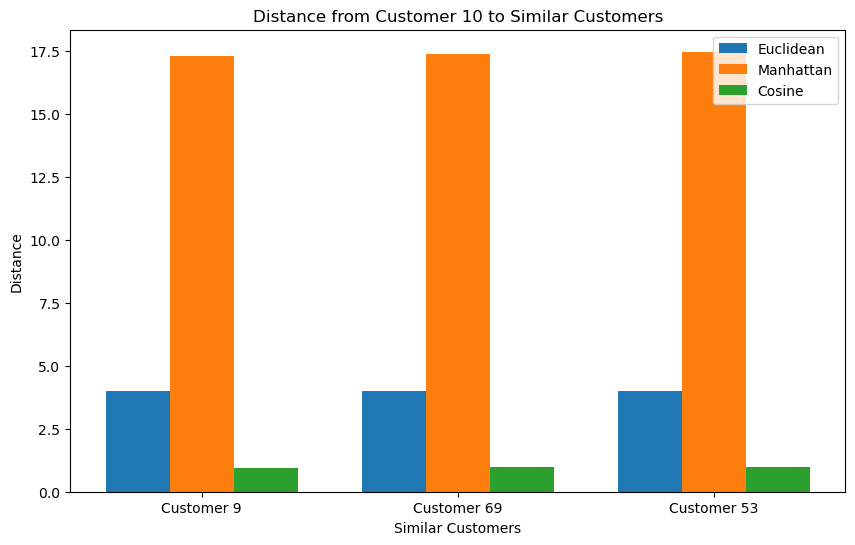

In [32]:
# Run this cell without changes
# Choose a reference customer for comparison
reference_id = 10
reference_customer = customers_df.iloc[reference_id - 1]

# Print information about the reference customer
print(f"Reference Customer (ID: {reference_id}):")
print(reference_customer)

# Compare similar customers found by each metric
print("\nTop 3 similar customers by Euclidean distance:")
for idx in euclidean_similar:
    print(f"Customer {idx+1}:")
    print(customers_df.iloc[idx])

print("\nTop 3 similar customers by Manhattan distance:")
for idx in manhattan_similar:
    print(f"Customer {idx+1}:")
    print(customers_df.iloc[idx])

print("\nTop 3 similar customers by Cosine distance:")
for idx in cosine_similar:
    print(f"Customer {idx+1}:")
    print(customers_df.iloc[idx])

# Create a simple visualization to compare metrics
plt.figure(figsize=(10, 6))
bar_width = 0.25
r1 = np.arange(len(euclidean_similar))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Get distances from reference customer to similar customers
euclidean_distances_to_similar = [euclidean_matrix[reference_id][i] for i in euclidean_similar]
manhattan_distances_to_similar = [manhattan_matrix[reference_id][i] for i in euclidean_similar]
cosine_distances_to_similar = [cosine_dist_matrix[reference_id][i] for i in euclidean_similar]

# Plot distances
plt.bar(r1, euclidean_distances_to_similar, width=bar_width, label='Euclidean')
plt.bar(r2, manhattan_distances_to_similar, width=bar_width, label='Manhattan')
plt.bar(r3, cosine_distances_to_similar, width=bar_width, label='Cosine')

plt.xlabel('Similar Customers')
plt.xticks([r + bar_width for r in range(len(euclidean_similar))], [f'Customer {i}' for i in euclidean_similar])
plt.ylabel('Distance')
plt.title(f'Distance from Customer {reference_id} to Similar Customers')
plt.legend()
plt.show()

Cosine has the smallest distance and manhattan has the greatest distance. Cosine distance focuses on direction, not magnitude. Manhattan distance is more sensitive to outliers. 

## Part 5: Create a Hybrid Distance Metric
Create a custom distance metric that combines multiple distance measures:

In [ ]:
# CodeGrade step4
# Create a function to calculate weighted distance
def weighted_hybrid_distances(X, weights=[0.4, 0.4, 0.2]):
    """
    Calculate a weighted hybrid distance matrix from multiple distance metrics

    Parameters:
    X: Feature matrix (normalized)
    weights: List of weights for [euclidean, manhattan, cosine]

    Returns:
    Weighted hybrid distance matrix
    """
    # Calculate individual distance matrices
    eucl_dist = euclidean_distances(X)
    manh_dist = manhattan_distances(X)
    cos_dist = 1 - cosine_similarity(X)

    # Normalize each distance matrix to have similar scales
    # For a simple approach, we'll divide by the max value
    eucl_dist = eucl_dist / np.max(eucl_dist)
    manh_dist = manh_dist / np.max(manh_dist)
    cos_dist = cos_dist / np.max(cos_dist)

    # Return weighted combination
    return (weights[0] * eucl_dist +
            weights[1] * manh_dist +
            weights[2] * cos_dist)

# Calculate hybrid distance matrix with default chosen weights
hybrid_matrix = weighted_hybrid_distances(features_df)

## Part 6: Evaluate Hybrid Distance Metric
In this step, you'll examine how the hybrid distance metric combines the strengths of other metrics to find meaningfully similar customers


In [36]:
# CodeGrade step5
# First, let's select a reference customer with clear spending preferences
reference_id = 16  # This customer is a high spender with two preferred categories

# Get reference customer details
reference = customers_df.iloc[reference_id - 1]
ref_total_spend = reference['clothing_spend'] + reference['accessories_spend'] + reference['footwear_spend']

# Calculate spending percentages to highlight preferences
clothing_pct = reference['clothing_spend'] / ref_total_spend * 100
accessories_pct = reference['accessories_spend'] / ref_total_spend * 100
footwear_pct = reference['footwear_spend'] / ref_total_spend * 100

# Find similar customers based on hybrid system
hybrid_matrix = weighted_hybrid_distances(features_df.values)
similar_customers = find_similar_customers(customer_id=16, distance_matrix=hybrid_matrix, n=5)

print("Top 5 similar customers to Customer 16:")
display(customers_df.iloc[similar_customers - 1])


Top 5 similar customers to Customer 16:


,customer_id,gender,age,income,years_customer,clothing_spend,accessories_spend,footwear_spend,preferred_channel,region
14,15,F,37,65000,5.9,220,105,95,store,northeast
46,47,F,38,66000,6.6,230,120,95,store,northeast
22,23,F,38,67000,6.4,235,115,95,online,northeast
26,27,F,29,48000,2.5,195,80,100,online,northeast
54,55,F,40,70000,7.1,240,120,95,store,northeast


In [37]:
# Run this cell without changes to display result
print(f"Reference Customer (ID: {reference_id}):")
print(f"Gender: {reference['gender']}, Age: {reference['age']}, Income: ${reference['income']}")
print(f"Spending: Clothing ${reference['clothing_spend']}, Accessories ${reference['accessories_spend']}, Footwear ${reference['footwear_spend']}")
print(f"Total spending: ${ref_total_spend:.2f}")

print(f"Spending breakdown: Clothing {clothing_pct:.1f}%, Accessories {accessories_pct:.1f}%, Footwear {footwear_pct:.1f}%")
print("This customer clearly prioritizes clothing and footwear.")
print(reference)

# Function to print customer details with spending breakdown
def print_customer_details(customer_idx, label=""):
    customer = customers_df.iloc[customer_idx]
    total = customer['clothing_spend'] + customer['accessories_spend'] + customer['footwear_spend']

    c_pct = (customer['clothing_spend'] / total) * 100
    a_pct = (customer['accessories_spend'] / total) * 100
    f_pct = (customer['footwear_spend'] / total) * 100

    print()
    print(f"{label} Customer {customer_idx + 1}:")
    print(f"  Gender: {customer['gender']}, Age: {customer['age']}, Income: ${customer['income']}")
    print(f"  Total spending: ${total:.2f}")
    print(f"  Spending: Clothing ${customer['clothing_spend']} ({c_pct:.1f}%), " +
          f"Accessories ${customer['accessories_spend']} ({a_pct:.1f}%), " +
          f"Footwear ${customer['footwear_spend']} ({f_pct:.1f}%)")
    print(customer)

# Compare each top most similar
for i, cust_id in enumerate(similar_customers, start=1):
    print_customer_details(cust_id - 1, f"Hybrid Similar #{i}")

Reference Customer (ID: 16):
Gender: M, Age: 52, Income: $98000
Spending: Clothing $160, Accessories $80, Footwear $150
Total spending: $390.00
Spending breakdown: Clothing 41.0%, Accessories 20.5%, Footwear 38.5%
This customer clearly prioritizes clothing and footwear.
customer_id                 16
gender                       M
age                         52
income                   98000
years_customer            11.8
clothing_spend             160
accessories_spend           80
footwear_spend             150
preferred_channel        store
region               southeast
Name: 15, dtype: object

Hybrid Similar #1 Customer 15:
  Gender: F, Age: 37, Income: $65000
  Total spending: $420.00
  Spending: Clothing $220 (52.4%), Accessories $105 (25.0%), Footwear $95 (22.6%)
customer_id                 15
gender                       F
age                         37
income                   65000
years_customer             5.9
clothing_spend             220
accessories_spend          105
f

## Conclusion
After comparing how different distance metrics find similar customers, the hybrid distance metric with weights works well for retail customer segmentation because:

1. It balances overall similarity (from Euclidean distance) with spending pattern similarity (from Cosine distance), which is important for effective marketing.

2. The Euclidean component (0.4 weight) ensures we find customers with similar demographics and total spending capacity.

3. The Manhattan component (0.4 weight) provides robustness when customers have unusual spending in one category.

4. The Cosine component (0.2 weight) helps identify customers with similar spending priorities (how they divide their budget), even if their total might differ spending differs.

5. In our tests, the hybrid approach found customers who were both demographically similar and had similar purchasing behaviors, making it more practical for targeted marketing campaigns.

This lab provided an exploration of distance metrics for customer similarity analysis in a retail context. By implementing and comparing Euclidean, Manhattan, and Cosine distance metrics, we demonstrated how different mathematical approaches to measuring similarity can yield different results.

The key takeaways include:

- Metric selection matters: Each distance metric emphasizes different aspects of similarity. Euclidean distance captures overall profile similarity, Manhattan distance offers robustness to outliers, and Cosine distance identifies similar preferences regardless of scale.
- Preprocessing is crucial: Proper handling of categorical variables through encoding and normalization of numerical features ensures fair comparison across different types and scales of data.
- Hybrid approaches offer balance: Combining multiple distance metrics with appropriate weights can create a more comprehensive similarity measure that captures both absolute and proportional similarity.
- Business context drives metric choice: The "best" distance metric depends on the specific business goals. For retail marketing, a hybrid approach balances spending capacity with customer preferences.
- Practical applications: Distance-based similarity measures can directly power recommendation systems, helping businesses identify cross-selling opportunities based on similar customers' behavior.

This approach to customer similarity analysis provides retail businesses with a powerful tool for personalized marketing, inventory planning, and customer relationship management.